## Intro

The main purpose of this notebook is to show how to use Spark to perform distributed training of ML models on the cluster (here we'll train a few Prophet models). The notebook also shows how to set up Hyperopt to orchestrate the hyperparameter search. Hyperopt is a general purpose library that can be used for the optimisation of any function that has parameters. Here it is used to optimise the prediction loss function (rmse). Additionally, some metrics will be tracked using MLflow. 

I decided to work with daily aggregated energy consumption data. The data shows a nice weekly and annual seasonality.

Simon B, 05.06.2023

In [0]:
%pip install prophet==1.1.4 hyperopt==0.2.7 sklearn mlflow

Python interpreter will be restarted.
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2360 sha256=45c621303b8342900a1b37b61bf30f4496f828436fd9f355d49d75b2e8a91469
  Stored in directory: /root/.cache/pip/wheels/36/49/c9/2374f1dee1b599effabf63d948635e6608f62d0ccde027b7e2
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143882 sha256=94b9fb14638d4df042d2c898b94a232c90f2c7299ea53395005330bab1eb9779
  Stored in directory: /root/.cache/pip/wheels/b6/90/68/94d223a35a3910c1512a8d42d9f8333ce567ef26e250a56227
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732018 sha256=ec2cfcb5ae33025df4f813944a9a29f0a1e21bbacf4779fb6f600481f25729f6
  Stored in directory: /root/.cache/pip/wheels/04/1f/e5/8dd0c661cd8d252817655dc14a84f7ae045d6616594145aa81
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492036 sha256=d10c19588e3688edc4aecfba35271e2ec51ebbb7019380d29d72f2b4281e6538
  Stored in 

## Imports

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

from hyperopt import fmin, hp, tpe
from hyperopt import SparkTrials, STATUS_OK
from prophet  import Prophet

import mlflow

## Setup MLflow

In [0]:
# Get the name of the experiment 
# You must create the expirement by hand in the Databricks Machine Learning Experiments GUI
# Then copy the name of the experiment and paste it here

experimentPath = "/Users/simon.buse@ewz.ch/MittelfristPrognoseTest"

if mlflow.get_experiment_by_name(experimentPath) != None:
  print(f"Experiment {experimentPath} exists, setting it as the active experiemnt")
  mlflow.set_experiment(experimentPath)
else:
  raise Exception('You must first create the experiment in the Databricks Machine Learning GUI')

Experiment /Users/simon.buse@ewz.ch/MittelfristPrognoseTest exists, setting it as the active experiemnt


## Define Functions

In [0]:
def logMetrics(test, predictions):
  '''
  Simple function to compute MAPE and RMSE metrics from test predictions and the test data for our models.
  The error metrics will be logged with MLflow.
  '''
  mapeValue = mean_absolute_percentage_error(test, predictions)
  rmseValue = mean_squared_error(test, predictions, squared=False)
  metrics = {"mape": mapeValue, "rmse": rmseValue}

  # MLflow will log the metrics to the currently active run
  mlflow.log_metrics(metrics)


def logParams(parameters):
  '''
  Parameters should be a dictionary with the form {"parameterName": "parameterValue"}
  '''
  for par in parameters:
    mlflow.log_params(par)

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour.
  The function will reassign any data points that are more than 3 sigma away from the mean. 
  This function will only correct outliers that are not consecutive.
  """

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating after a resampling and as a simple fix i will just delete 
  the first and the last value if they deviate more than 20% from their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 

  return pdf

## Prepare the Data

In [0]:
url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
pdf = pd.read_csv(url,index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)

pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Drop the timezone to avoid warnings
pdf["ds"]= pdf.index

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


,Value_NE5,Value_NE7,ds
Timestamp,,,
2015-01-01,2.146054e+06,4.563033e+06,2015-01-01
2015-01-02,2.238787e+06,4.834561e+06,2015-01-02
2015-01-03,2.226526e+06,4.923018e+06,2015-01-03
2015-01-04,2.069093e+06,4.655374e+06,2015-01-04
2015-01-05,2.792374e+06,5.792671e+06,2015-01-05
...,...,...,...
2023-06-17,2.186101e+06,4.049385e+06,2023-06-17
2023-06-18,2.067528e+06,3.812508e+06,2023-06-18
2023-06-19,2.645318e+06,4.765317e+06,2023-06-19


In [0]:
# Adding the corona period as one-off holidays to the prophet model https://facebook.github.io/prophet/docs/handling_shocks.html
corona = pd.DataFrame({
  'holiday': 'corona',
  'ds': pd.date_range(start='2020-03-01', end='2020-12-31', freq='D'),  #these dates are just an example
  'lower_window': 0,
  'upper_window': (pd.to_datetime('2020-12-31') - pd.to_datetime('2020-03-01')).days,
})

## Define the Model and the Search Space

In [0]:
def train_prophet(pdfTrain,pdfTest,tracked_hyperparams, maxEvals=10,timeoutSec=5*60):
  """This function is just a wrapper for the hyperopt procedure."""

  def train(params):
    """
    This is our main training function which we pass to Hyperopt.
    It takes in hyperparameter settings, fits a model based on those settings,
    evaluates the model, and returns the loss. 
    """

    if tracked_hyperparams["corona"] == True:
      forecaster = Prophet(
        holidays                = corona,
        seasonality_mode        = tracked_hyperparams['seasonality_mode'],
        changepoint_prior_scale = params['changepoint_prior_scale'],
        seasonality_prior_scale = params['seasonality_prior_scale'],
        holidays_prior_scale    = params['holidays_prior_scale'],
        changepoint_range       = params['changepoint_range'])
      
    else:
      forecaster = Prophet(
        seasonality_mode        = tracked_hyperparams['seasonality_mode'],
        changepoint_prior_scale = params['changepoint_prior_scale'],
        seasonality_prior_scale = params['seasonality_prior_scale'],
        holidays_prior_scale    = params['holidays_prior_scale'],
        changepoint_range       = params['changepoint_range'])

    if tracked_hyperparams["holidays"] != None:   
      forecaster.add_country_holidays(country_name=tracked_hyperparams["holidays"])

    forecaster.fit(pdfTrain)  
    y_pred = forecaster.predict(pdfTest)

    rmse   = mean_squared_error(y_true=pdfTest.y.values, y_pred=y_pred.yhat.values, squared=False)  

    return {'loss': rmse, 'status': STATUS_OK, 'Trained_Model': forecaster}
   
  # Define the search space for Hyperopt.Prophets main parameter where found here
  # https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning 

  search_space = {
    "changepoint_prior_scale": hp.loguniform("changepoint_prior_scale", -6.9, -0.69), #equivalent to [0.001,0.5]
    "seasonality_prior_scale": hp.loguniform("seasonality_prior_scale", -6.9, 2.3),   #equivalent to [0.001, 10]
    "holidays_prior_scale":    hp.loguniform("holidays_prior_scale", -6.9, 2.3),      #equivalent to [0.001, 10]
    "changepoint_range":       hp.uniform("changepoint_range", 0.8,0.95)              #optional according to docs, default = 0.8               
  }

  # Select a search algorithm for Hyperopt to use.
  algo=tpe.suggest  # Tree of Parzen Estimators, a Bayesian method

  # Distribute tuning across our Spark cluster
  spark_trials = SparkTrials(parallelism=4)

  best_hyperparameters = fmin(fn=train,space=search_space,algo=algo,trials=spark_trials,max_evals=maxEvals,timeout=timeoutSec)
  best_model = spark_trials.results[np.argmin([r['loss'] for r in spark_trials.results])]['Trained_Model']

  print(best_hyperparameters)
  return best_model,best_hyperparameters

## Train a model

In [0]:
#train singel model on the sum of the two columns, let's add the tracking with Mlflow and comparison

sum_pdf = pdf.copy()
sum_pdf["total"] = pdf["Value_NE5"].values + pdf["Value_NE7"].values
sum_pdf = sum_pdf.drop(columns=["Value_NE5","Value_NE7"])
sum_pdf = sum_pdf.rename(columns={"total": "y"})
split = int(len(sum_pdf)*0.9)
pdf_train, pdf_test = sum_pdf.iloc[:split], sum_pdf.iloc[split:]


#define the hyperparams to track: holidays, additive or multiplicative, adding corona by hand or not, 
tracked_hyperparams =   {"seasonality_mode":['multiplicative','additive'], 
                         "corona":          [False, True],
                         "holidays":        [None, 'Switzerland']}

grid = ParameterGrid(tracked_hyperparams)

for evaluation_params in grid:
  
  # Create an MLflow run for each point in the grid space. 
  # The "with" syntax means the run will be closed once the following block of code is finished.
  with mlflow.start_run(run_name = "Prophet Model") as run:
    
    # Set a tag with the model type
    mlflow.set_tags({"Model": "Prophet"})

    #create, train and return model
    print(evaluation_params)
    best_model,best_hyperparameters = train_prophet(pdf_train,pdf_test, evaluation_params)

    prediction = best_model.predict(pdf_test) 

    # Log the metrics in MLflow 
    logMetrics(pdf_test.y.values, prediction.yhat.values)

    # Log hyperparameters
    logParams([best_hyperparameters,evaluation_params])





{'corona': False, 'holidays': None, 'seasonality_mode': 'multiplicative'}
100%|██████████| 10/10 [00:19<00:00,  1.90s/trial, best loss: 272214.36703441606]
Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
{'changepoint_prior_scale': 0.0010263016882900542, 'changepoint_range': 0.869817705965029, 'holidays_prior_scale': 0.03708427999348185, 'seasonality_prior_scale': 0.38566036855519154}
{'corona': False, 'holidays': None, 'seasonality_mode': 'additive'}
100%|██████████| 10/10 [00:12<00:00,  1.21s/trial, best loss: 360566.9003865603]
Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
{'changepoint_prior_scale': 0.2562618249756159, 'changepoint_range': 0.88984999044923, 'holidays_prior_scale': 0.028316853852474705, 'seasonality_prior_scale': 0.8602510288232518}
{'corona': False, 'holidays': 'Switzerland', 'seasonality_mode': 'multiplicative'}
100%|██████████| 10/10 [00:13<00:00,  1.30s/trial, best loss: 264545.3009606626]
Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
{'

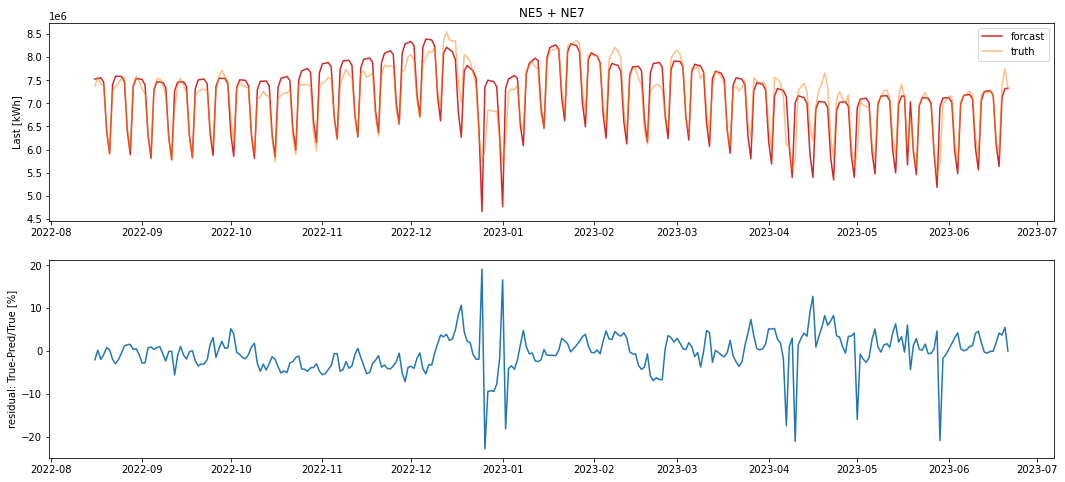

In [0]:
#plot the outcome of the model on the summed data.

f, axes = plt.subplots(2, 1,figsize=(18,8))

y_pred = best_model.predict(pdf_test)

axes[0].plot(y_pred.ds.values, y_pred.yhat.values, color="tab:red", label="forcast")
#axes[0].plot(pdf_train.ds.values, pdf_train.y.values, color="tab:blue", label="train")
axes[0].plot(pdf_test.ds.values, pdf_test.y.values, color="tab:orange", label="truth", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [kWh]")


xmin, xmax = axes[0].get_xlim()

axes[1].plot(pdf_test.ds,(pdf_test.y.values-y_pred.yhat.values)/(pdf_test.y.values)*100)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: True-Pred/True [%]")

plt.show()

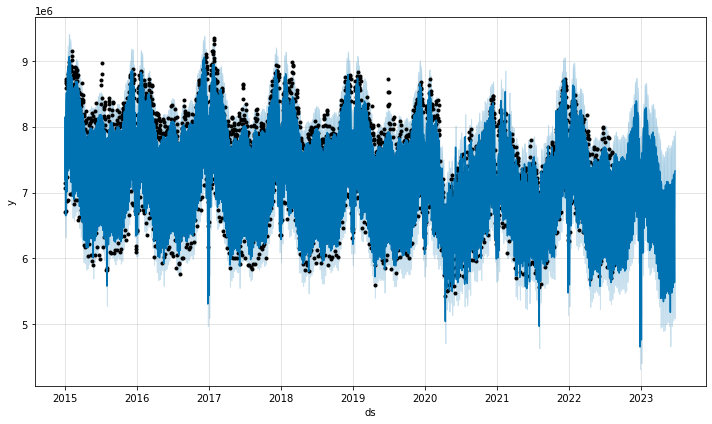

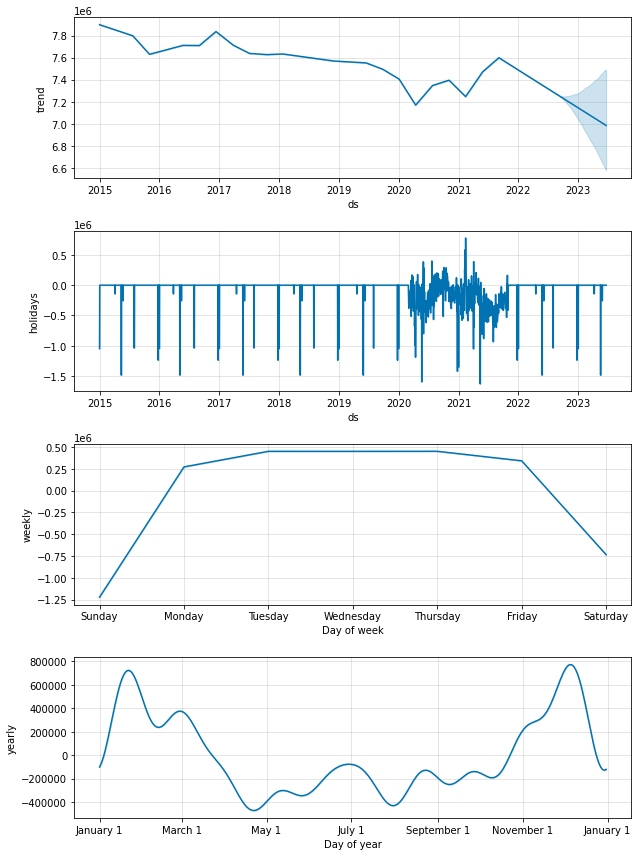

In [0]:
forecast = best_model.predict(pdf)
best_model.plot(forecast)
fig = best_model.plot_components(forecast)